# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
%matplotlib inline

from yellowbrick.cluster import KElbowVisualizer

random_state = 727
maxCluster = 15
sd = dt.datetime(2015,12,19)

In [2]:
df = pd.read_csv("eshop.csv", parse_dates=['Date']).drop(columns=['Country'])

data si nejdrive  prevedu do rfm tabulky

* hist = 0 pokud zakaznik nakoupil dnes, jinak udava pocet dnu dnu od konkretniho zaznamu nakupu
    * od toho se take odviji recency - minimum tj kdy nakoupil naposled
* frequency je pocet zaznamu s danym ID zakaznika
* monetary jako soucet vsech hodnot 

In [3]:
rfmTable = df.copy()
rfmTable['hist']=sd - rfmTable['Date']
rfmTable['hist'].astype('timedelta64[D]')
rfmTable['hist']= rfmTable['hist'] / np.timedelta64(1, 'D')
rfmTable['hist'] = rfmTable['hist'].astype('int64')
rfmTable = rfmTable.drop(columns=['Date'])

rfmTable = rfmTable.groupby('Customer ID').agg({ 'hist': lambda x: x.min(),
                                               'Customer ID': lambda x: len(x),
                                               'Subtotal': lambda x: x.sum()}
                                          ).rename(columns={'hist':'recency', 
                                                            'Customer ID' : 'frequency',
                                                            'Subtotal' : 'monetary'})

rfmTable['monetary'] = rfmTable['monetary'].astype('int64')

In [4]:
def visualize(X):
    for i in range(2, 10):
        rfmTableWithClusters = X.copy()
        rfmTableWithClusters['cluster'] = KMeans(n_clusters = i, random_state=random_state).fit_predict(rfmTableWithClusters)
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111, projection='3d')
        s = ax.scatter(xs=rfmTableWithClusters['frequency'], ys=rfmTableWithClusters['recency'], zs=rfmTableWithClusters['monetary'],
                   c=rfmTableWithClusters['cluster'], cmap="brg")
        ax.set_zlabel('monetary')
        ax.set_xlabel('frequency')
        ax.set_ylabel('recency')
        ax.set_title('k = ' + str(i))
        ax.legend(*s.legend_elements())
        plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


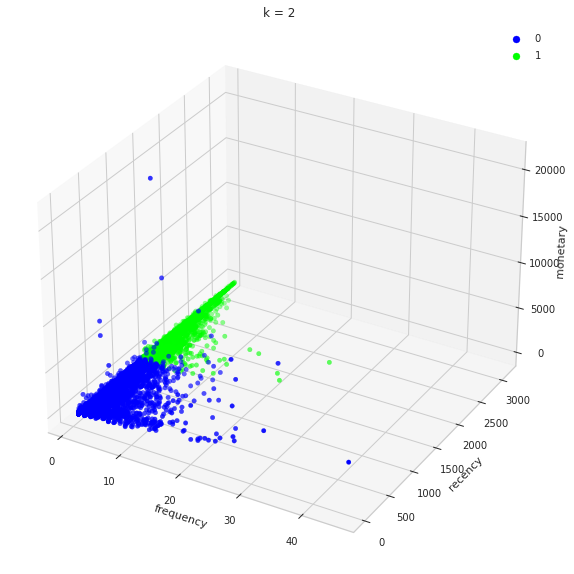

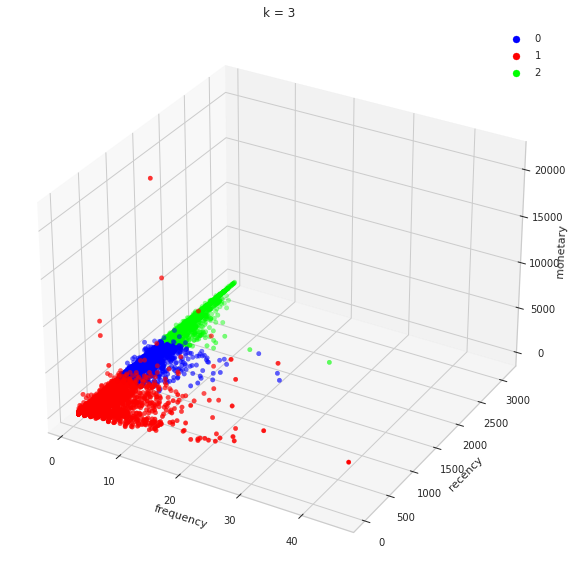

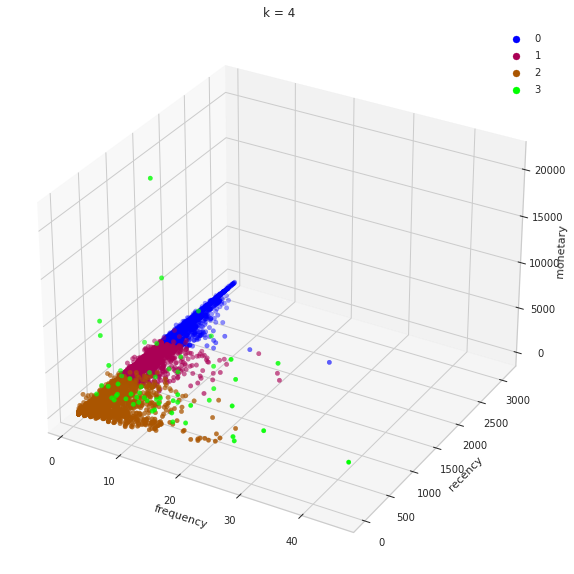

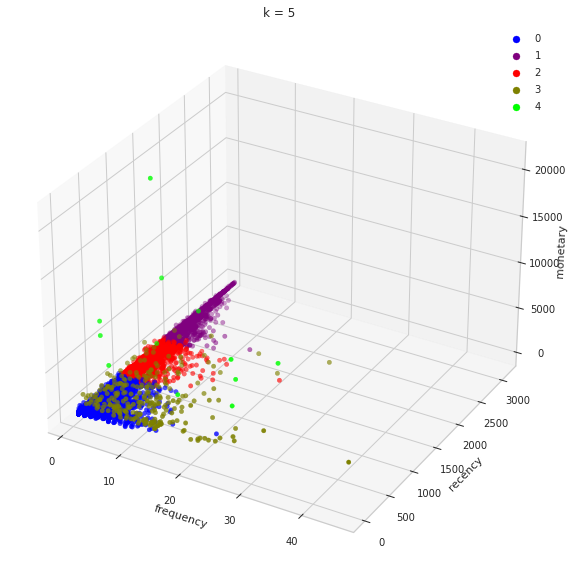

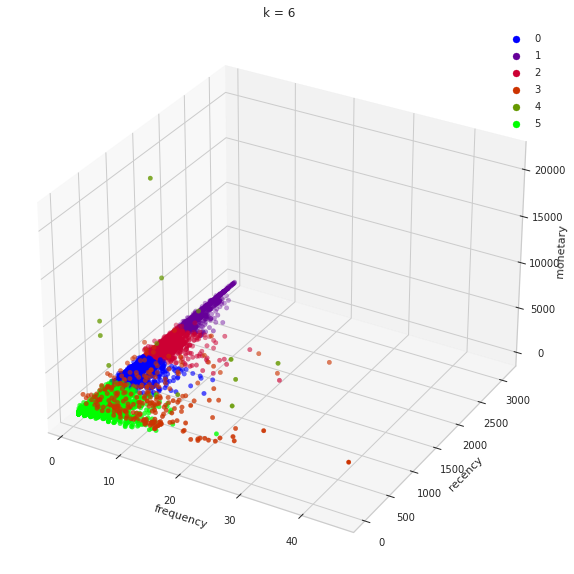

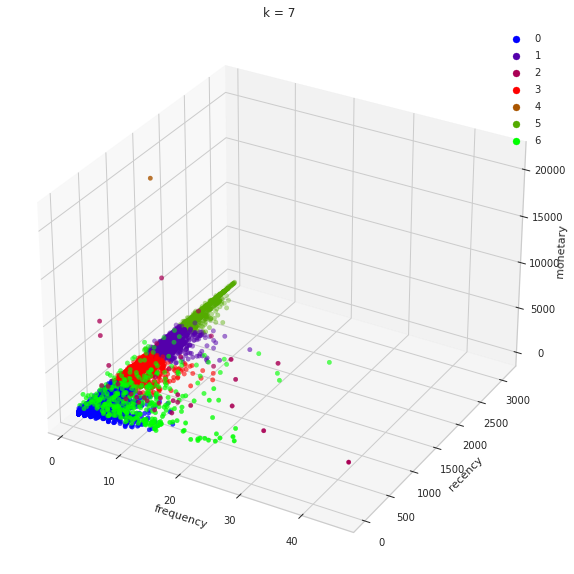

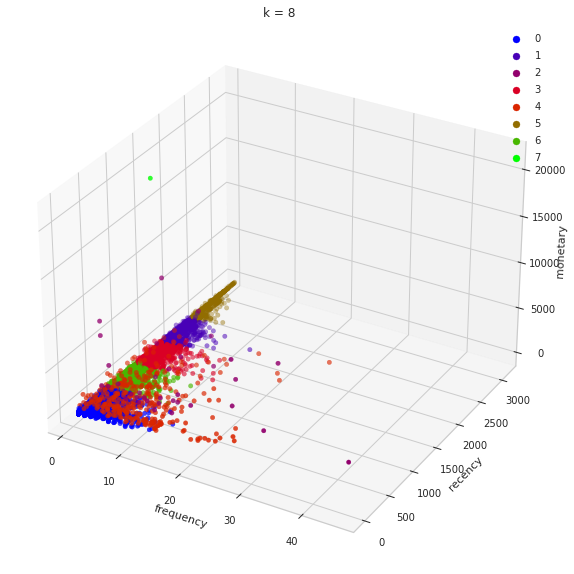

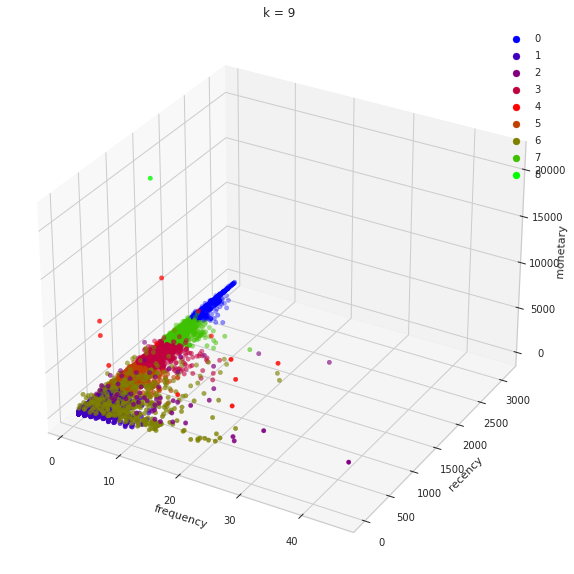

In [5]:
visualize(rfmTable)

* nalezeni elbow - optimalni pocet clusteru, z grafu je zrejme ze pro neupraveny data je 4
* distortion score je ale opravdu vysoky

* nyni si data trochu poupravim (preskalovani)
* vsechny hodnoty si rozdelim do 4 casti a podle hodnot rozskatulkuju do [1..4]

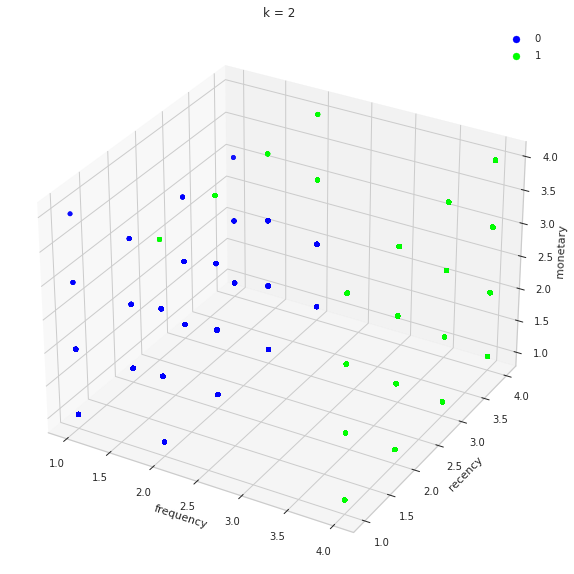

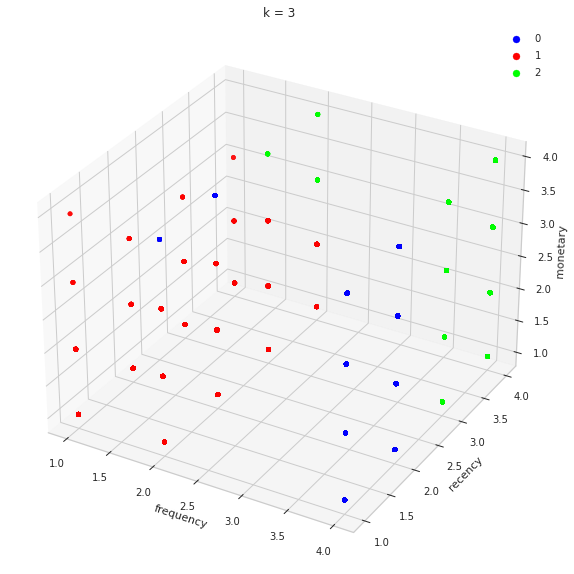

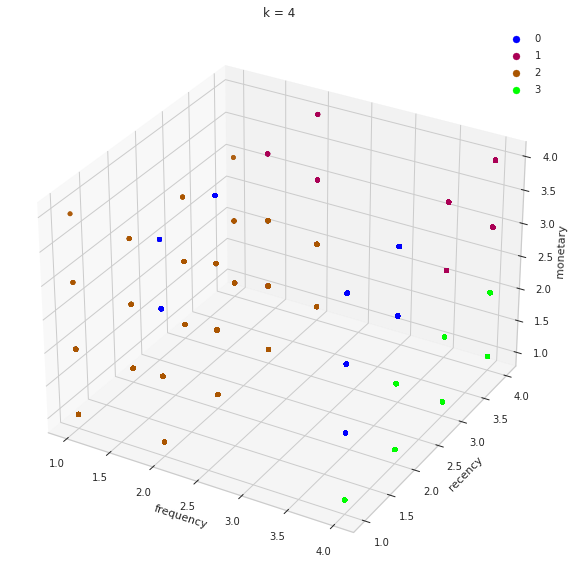

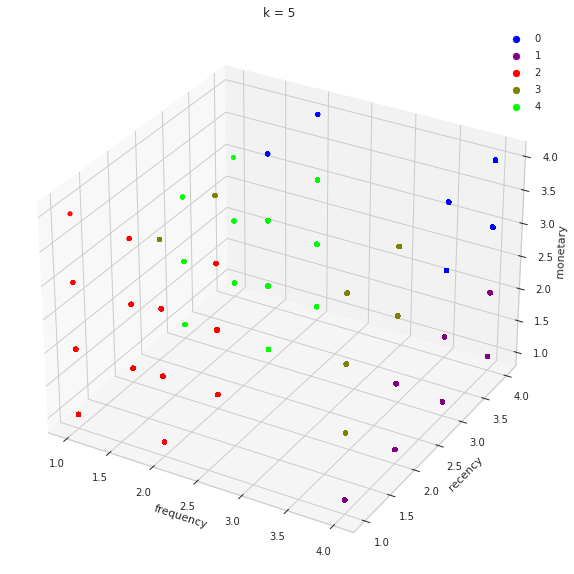

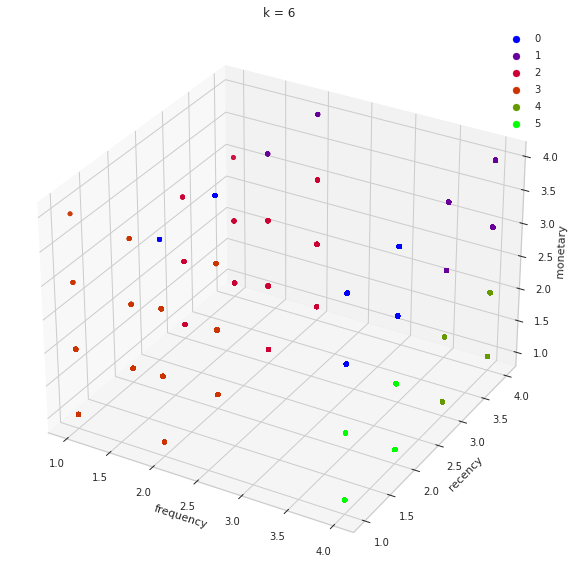

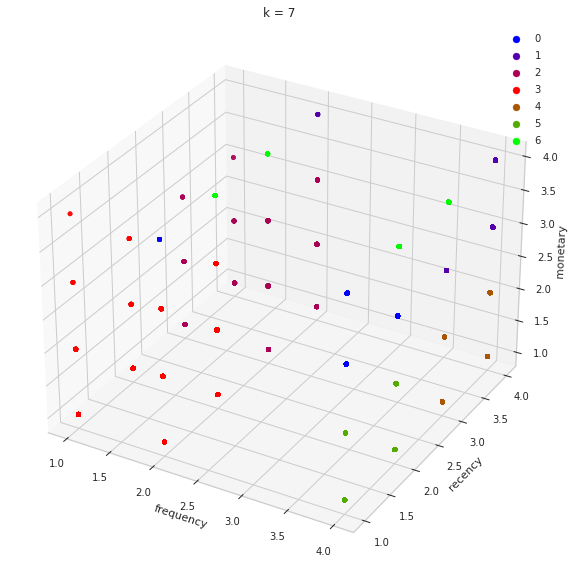

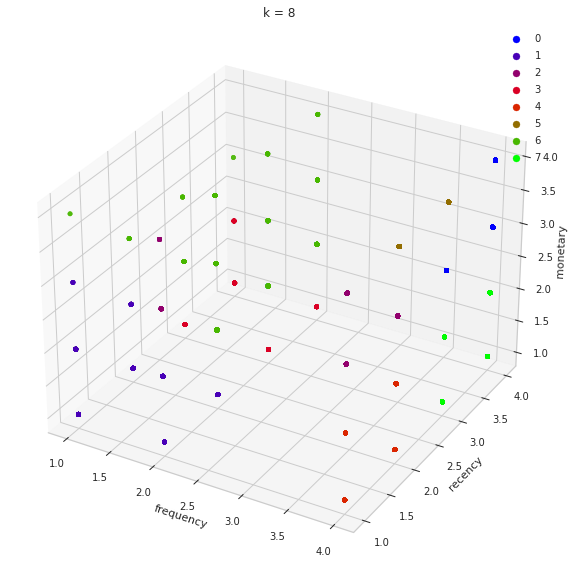

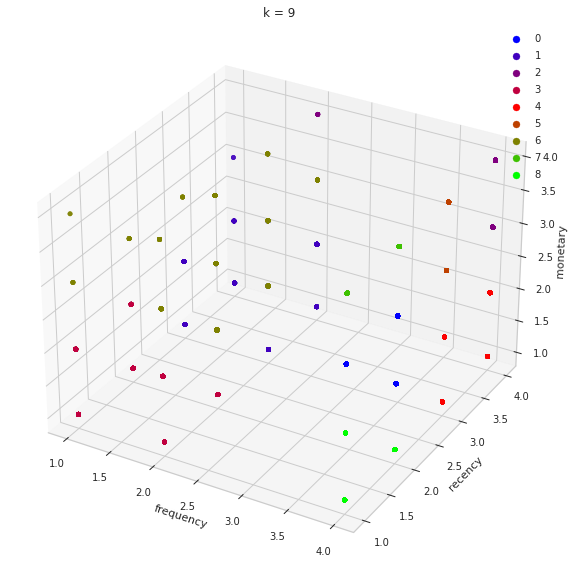

In [6]:
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])

# for Recency 
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# for Frequency and Monetary value 
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1    

rfmSeg = rfmTable.copy()
rfmSeg['recency'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['frequency'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['monetary'] = rfmSeg['monetary'].apply(FMClass, args=('monetary',quartiles,))

visualize(rfmSeg)

* data zde znormalizuji pomoci minmaxScaler

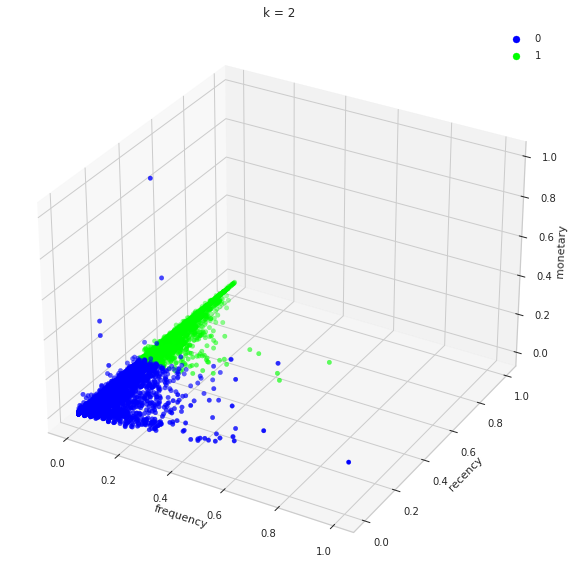

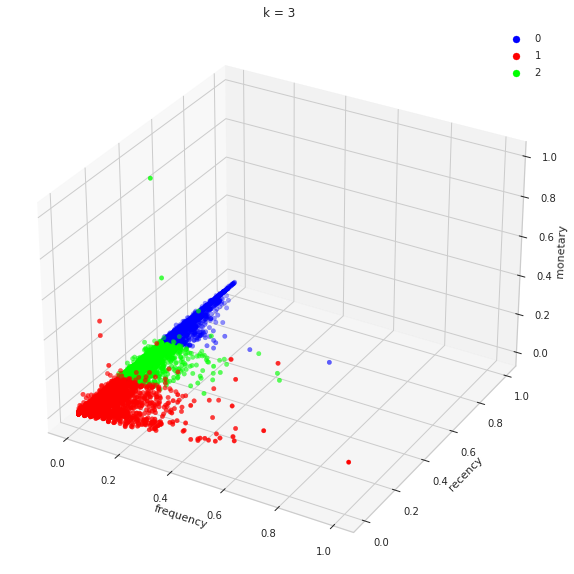

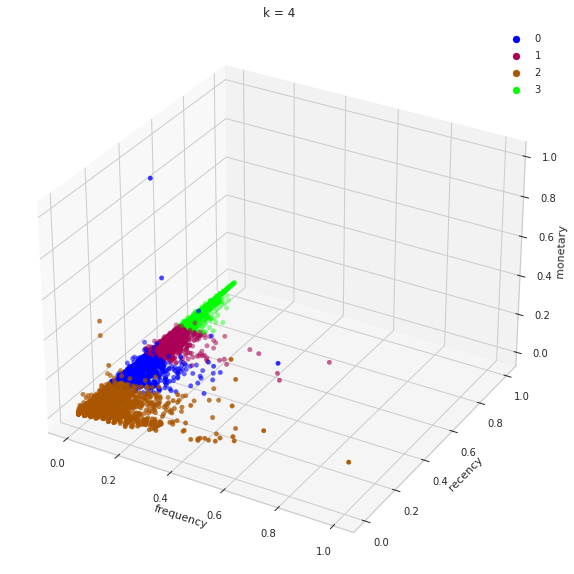

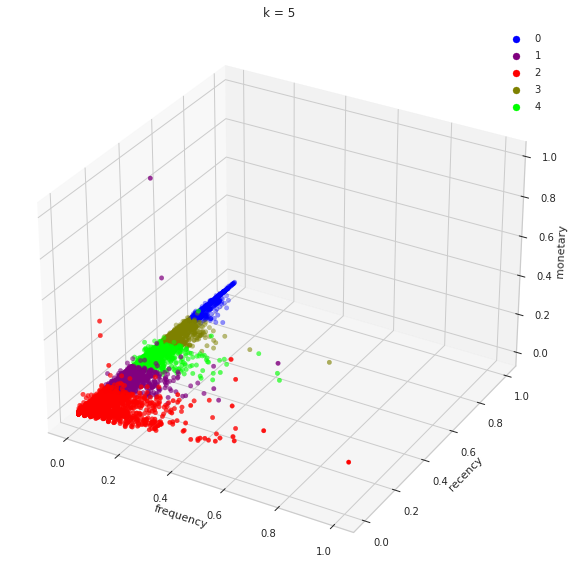

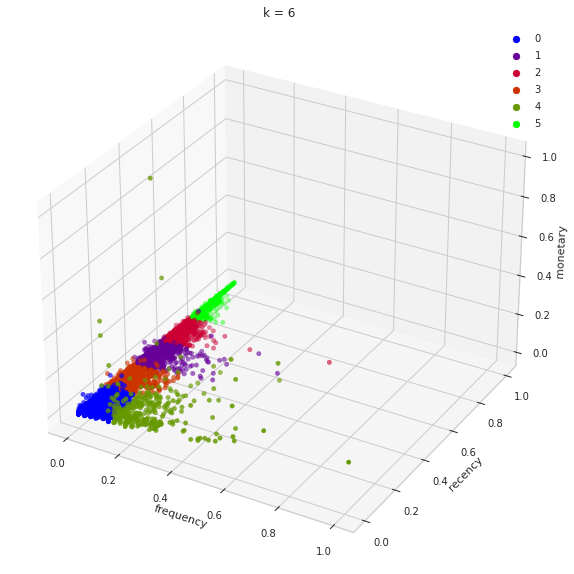

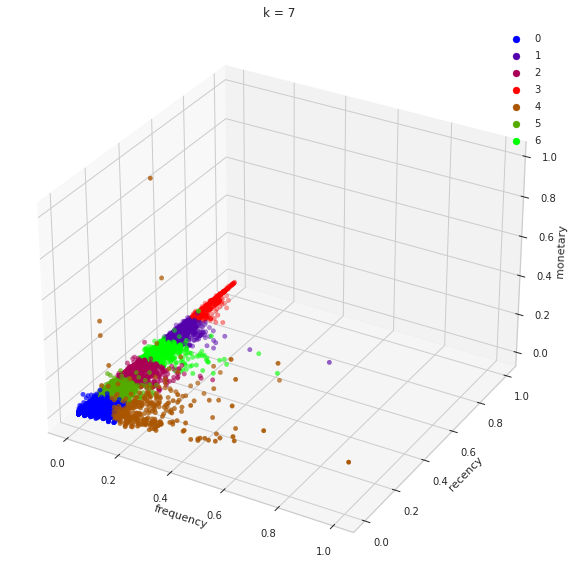

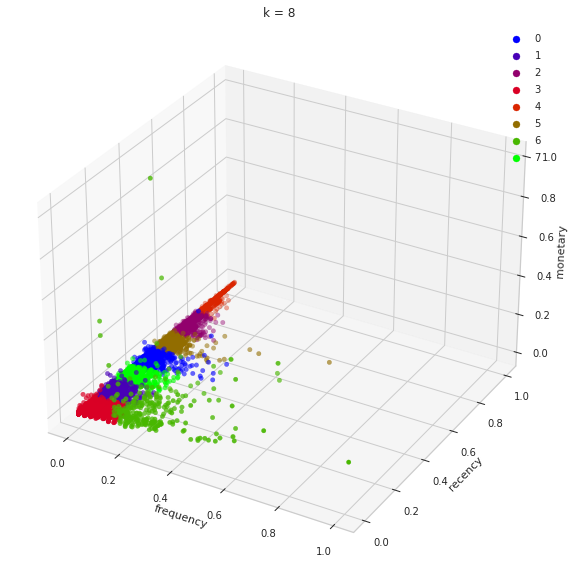

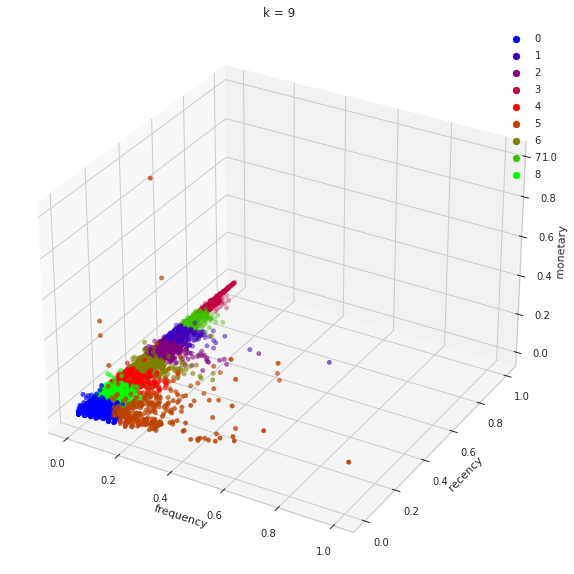

In [7]:
scaler = MinMaxScaler()
rfmScaled = pd.DataFrame(scaler.fit_transform(rfmTable),index=rfmTable.index, columns=rfmTable.columns)
visualize(rfmScaled)

In [8]:
idealClusters = 3

In [9]:
rfmTableWithClusters = rfmScaled.copy()
rfmTableWithClusters['cluster'] = KMeans(n_clusters = idealClusters, random_state=random_state).fit_predict(rfmTableWithClusters)

meanRec = []
meanFreq = []
meanMon = []
clusters = range(idealClusters)

for x in clusters:
    cluster = rfmTableWithClusters[rfmTableWithClusters['cluster'] == x]
    meanRec.append( cluster['recency'].mean())
    meanFreq.append(cluster['frequency'].mean())
    meanMon.append(cluster['monetary'] .mean())
    
meanrfm = pd.DataFrame(clusters, columns = ['clusters'])
meanrfm['mean recency'] = meanRec
meanrfm['mean frequency'] = meanFreq
meanrfm['mean monetary'] = meanMon

meanrfm

,clusters,mean recency,mean frequency,mean monetary
0,0,0.106639,0.028915,0.010634
1,1,0.375653,0.012883,0.006263
2,2,0.660210,0.006517,0.003925


## doplnujici ukol 1

In [10]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(rfmTable, KMeans(n_clusters = idealClusters, random_state=random_state).fit_predict(rfmTable))
print("For n_clusters =", idealClusters, "with no scaling, the average silhouette_score is :", silhouette_avg)

silhouette_avg = silhouette_score(rfmScaled, KMeans(n_clusters = idealClusters, random_state=random_state).fit_predict(rfmScaled))
print("For n_clusters =", idealClusters, "with no minMax scaling, the average silhouette_score is :", silhouette_avg)

silhouette_avg = silhouette_score(rfmSeg, KMeans(n_clusters = idealClusters, random_state=random_state).fit_predict(rfmSeg))
print("For n_clusters =", idealClusters, "with segmented scaling, the average silhouette_score is :", silhouette_avg)

For n_clusters = 3 with no scaling, the average silhouette_score is : 0.49325781279087005
For n_clusters = 3 with no minMax scaling, the average silhouette_score is : 0.5398500388758981
For n_clusters = 3 with segmented scaling, the average silhouette_score is : 0.4299150191563264


For n_clusters = 2 The average silhouette_score is : 0.5840498728834911
For n_clusters = 3 The average silhouette_score is : 0.5398500388758981
For n_clusters = 4 The average silhouette_score is : 0.50103757060209
For n_clusters = 5 The average silhouette_score is : 0.49165759083258


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


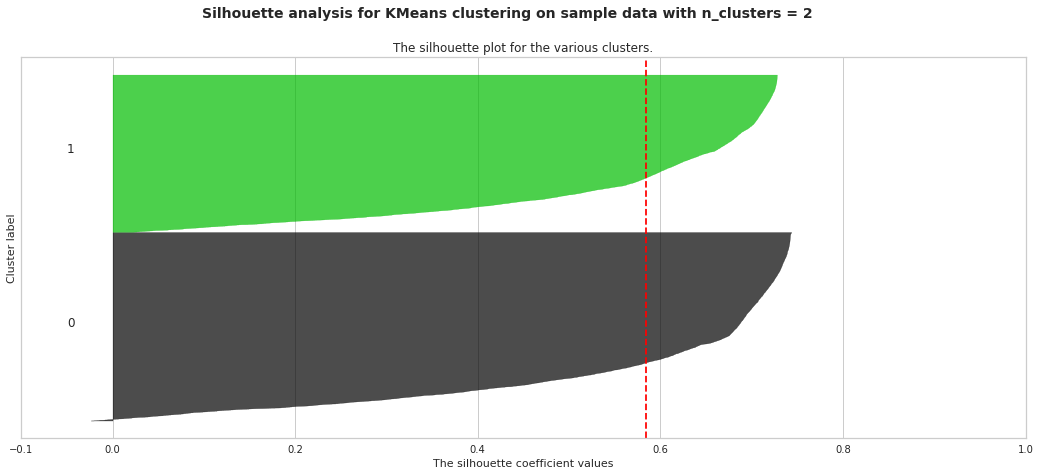

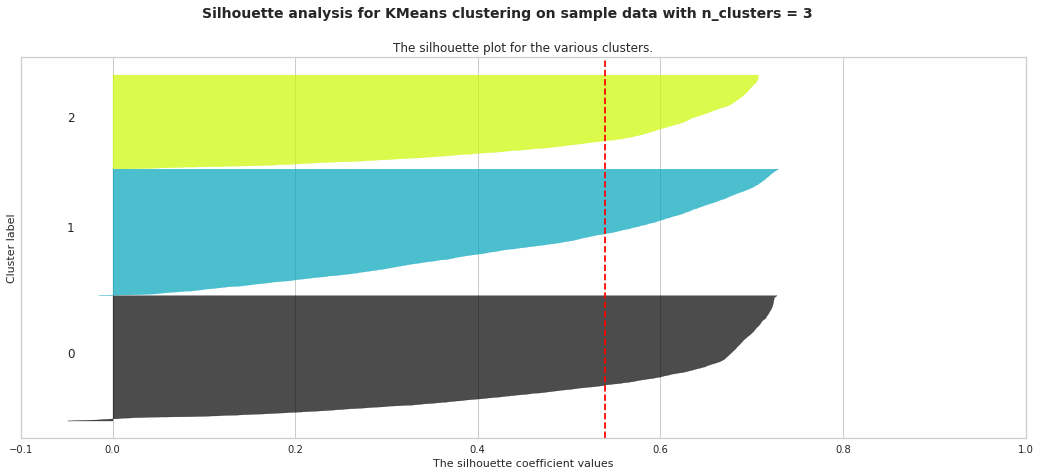

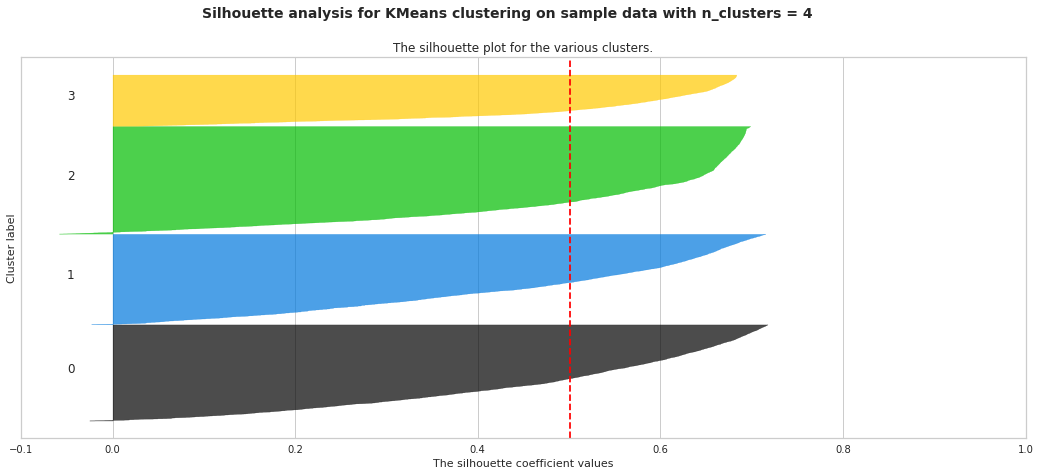

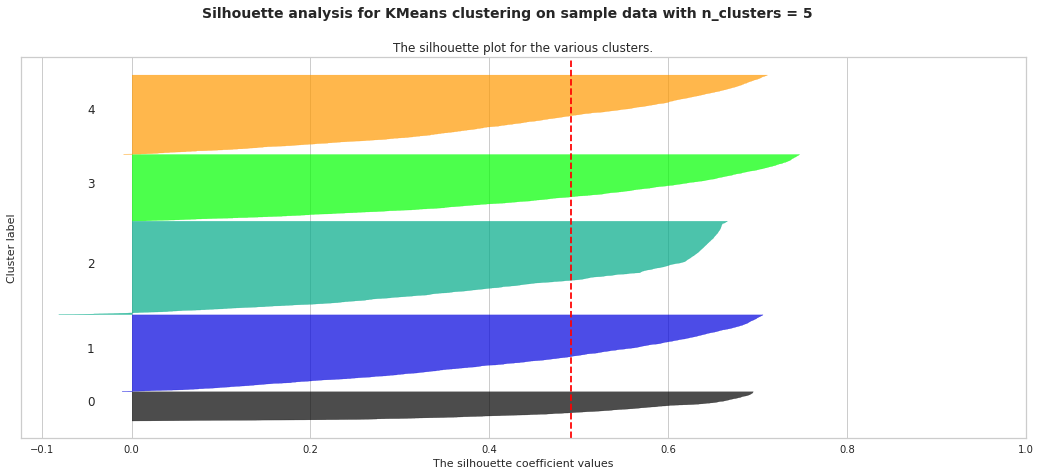

In [11]:
#code taken and modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
#uses X as datapoint to create graphs

X=rfmScaled

range_n_clusters = range(2, 6)

for n_clusters in range_n_clusters:
    fig, ax1= plt.subplots()
    fig.set_size_inches(18, 7)

    
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## doplnujici ukol 2
RFM, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

reseni recency je zrejmy

frequency - predtim nez jsem agregoval tak nastavil hodnotu na 1 pokud zakaznik nakoupil v poslednich 12 mesicu, 0 jinak a pote secetl

monetary jako max ze vsech vyskytu

,recency,freqencyLastYear,monetaryLastYear
Customer ID,,,
7,10,1,13.28
9,100,0,13.20
30,99,0,36.20
34,101,0,86.00
38,101,0,38.40
...,...,...,...
15356,1,1,31.87
15357,1,1,6.10
15358,1,1,153.23


KeyError: 'frequency'

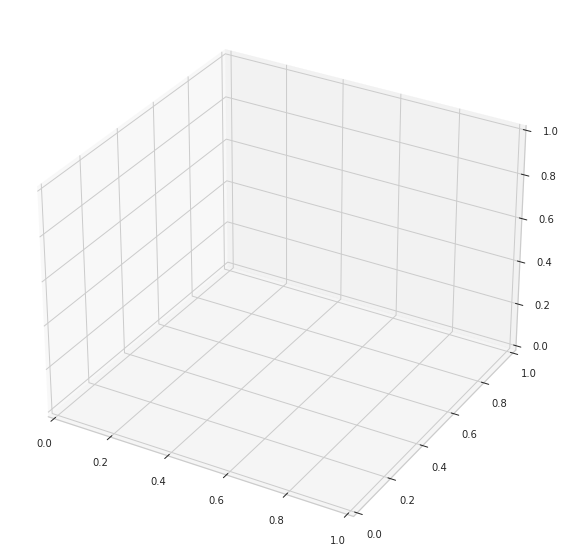

In [12]:
rfmModified = df.copy()
rfmModified['hist']=sd - rfmModified['Date']
rfmModified['hist'].astype('timedelta64[M]')
rfmModified['hist']= rfmModified['hist'] / np.timedelta64(1, 'M')
rfmModified['hist'] = rfmModified['hist'].astype('int64')
rfmModified = rfmModified.drop(columns=['Date'])

rfmModified['freqencyLastYear'] = np.zeros(len(rfmModified))
rfmModified['freqencyLastYear'] = rfmModified['freqencyLastYear'].astype('int64')
rfmModified.loc[rfmModified['hist']<=12 ,'freqencyLastYear']+=1

rfmModified = rfmModified.groupby('Customer ID').agg({ 'hist': lambda x: max(x.min(), 1),
                                                      'freqencyLastYear': lambda x: sum(x),
                                               'Subtotal': lambda x: x.max()}
                                          ).rename(columns={'hist':'recency', 
                                                            'Subtotal' : 'monetaryLastYear'})
display(rfmModified)
visualize(rfmModified)

idealni je opet 3

In [ ]:
scaler = MinMaxScaler()
rfmModifiedScaled = pd.DataFrame(scaler.fit_transform(rfmModified),index=rfmModified.index, columns=rfmModified.columns)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,maxCluster))

visualizer.fit(rfmModifiedScaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure